# Tutorial: Modeling 2D Darcy Flow with the Fourier Neural Operator

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial5/tutorial.ipynb)

In this tutorial, we are going to solve the **Darcy flow problem** in two dimensions, as presented in the paper [*Fourier Neural Operator for Parametric Partial Differential Equations*](https://openreview.net/pdf?id=c8P9NQVtmnO).

We begin by importing the necessary modules for the tutorial:


In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"
    !pip install scipy
    # get the data
    !wget https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial5/Data_Darcy.mat

import torch
import matplotlib.pyplot as plt
import warnings

from scipy import io
from pina.model import FNO, FeedForward
from pina import Trainer
from pina.solver import SupervisedSolver
from pina.problem.zoo import SupervisedProblem

warnings.filterwarnings("ignore")

## Data Generation

We will focus on solving a specific PDE: the **Darcy Flow** equation. This is a second-order elliptic PDE given by:

$$
-\nabla\cdot(k(x, y)\nabla u(x, y)) = f(x, y), \quad (x, y) \in D.
$$

Here, $u$ represents the flow pressure, $k$ is the permeability field, and $f$ is the forcing function. The Darcy flow equation can be used to model various systems, including flow through porous media, elasticity in materials, and heat conduction.

In this tutorial, the domain $D$ is defined as a 2D unit square with Dirichlet boundary conditions. The dataset used is taken from the authors' original implementation in the referenced paper.

In [2]:
# download the dataset
data = io.loadmat("Data_Darcy.mat")

# extract data (we use only 100 data for train)
k_train = torch.tensor(data["k_train"], dtype=torch.float)
u_train = torch.tensor(data["u_train"], dtype=torch.float)
k_test = torch.tensor(data["k_test"], dtype=torch.float)
u_test = torch.tensor(data["u_test"], dtype=torch.float)
x = torch.tensor(data["x"], dtype=torch.float)[0]
y = torch.tensor(data["y"], dtype=torch.float)[0]

Before diving into modeling, it's helpful to visualize some examples from the dataset. This will give us a better understanding of the input (permeability field) and the corresponding output (pressure field) that our model will learn to predict.

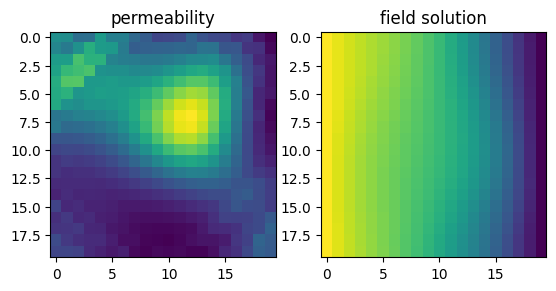

In [4]:
plt.subplot(1, 2, 1)
plt.title("permeability")
plt.imshow(k_train[0])
plt.subplot(1, 2, 2)
plt.title("field solution")
plt.imshow(u_train[0])
plt.show()

We now define the problem class for learning the Neural Operator. Since this task is essentially a supervised learning problem—where the goal is to learn a mapping from input functions to output solutions—we will use the `SupervisedProblem` class provided by **PINA**.

In [6]:
# make problem
problem = SupervisedProblem(
    input_=k_train.unsqueeze(-1), output_=u_train.unsqueeze(-1)
)

## Solving the Problem with a Feedforward Neural Network

We begin by solving the Darcy flow problem using a standard Feedforward Neural Network (FNN). Since we are approaching this task with supervised learning, we will use the `SupervisedSolver` provided by **PINA** to train the model.

In [7]:
# make model
model = FeedForward(input_dimensions=1, output_dimensions=1)


# make solver
solver = SupervisedSolver(problem=problem, model=model, use_lt=False)

# make the trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=False,
    batch_size=10,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


The final loss is relatively high, indicating that the model might not be capturing the solution accurately. To better evaluate the model's performance, we can compute the error using the `LpLoss` metric.

In [9]:
from pina.loss import LpLoss

# make the metric
metric_err = LpLoss(relative=False)

model = solver.model
err = (
    float(
        metric_err(u_train.unsqueeze(-1), model(k_train.unsqueeze(-1))).mean()
    )
    * 100
)
print(f"Final error training {err:.2f}%")

err = (
    float(metric_err(u_test.unsqueeze(-1), model(k_test.unsqueeze(-1))).mean())
    * 100
)
print(f"Final error testing {err:.2f}%")

Final error training 28.54%
Final error testing 28.58%


## Solving the Problem with a Fourier Neural Operator

We will now solve the Darcy flow problem using a Fourier Neural Operator (FNO). Since we are learning a mapping between functions—i.e., an operator—this approach is more suitable and often yields better performance, as we will see.

In [10]:
# make model
lifting_net = torch.nn.Linear(1, 24)
projecting_net = torch.nn.Linear(24, 1)
model = FNO(
    lifting_net=lifting_net,
    projecting_net=projecting_net,
    n_modes=8,
    dimensions=2,
    inner_size=24,
    padding=8,
)


# make solver
solver = SupervisedSolver(problem=problem, model=model, use_lt=False)

# make the trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=False,
    batch_size=10,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


We can clearly observe that the final loss is significantly lower when using the FNO. Let's now evaluate its performance on the test set.

Note that the number of trainable parameters in the FNO is considerably higher compared to a `FeedForward` network. Therefore, we recommend using a GPU or TPU to accelerate training, especially when working with large datasets.

In [11]:
model = solver.model
err = (
    float(
        metric_err(u_train.unsqueeze(-1), model(k_train.unsqueeze(-1))).mean()
    )
    * 100
)
print(f"Final error training {err:.2f}%")

err = (
    float(metric_err(u_test.unsqueeze(-1), model(k_test.unsqueeze(-1))).mean())
    * 100
)
print(f"Final error testing {err:.2f}%")

Final error training 3.52%
Final error testing 3.67%


As we can see, the loss is significantly lower with the Fourier Neural Operator!

## What's Next?

Congratulations on completing the tutorial on solving the Darcy flow problem using **PINA**! There are many potential next steps you can explore:

1. **Train the network longer or with different hyperparameters**: Experiment with different configurations of the neural network. You can try varying the number of layers, activation functions, or learning rates to improve accuracy.

2. **Solve more complex problems**: The Darcy flow problem is just the beginning! Try solving other complex problems from the field of parametric PDEs. The original paper and **PINA** documentation offer many more examples to explore.

3. **...and many more!**: There are countless directions to further explore. For instance, you could try to add physics informed learning!

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).